In [1]:
#Name : Manahil Sarwar
#Section : AI-K
#Roll No : 21I-0293

In [2]:
!pip install rouge

In [3]:
#Importing Libraries
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import itertools
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns

## 1. Transformer based translation

### Preprocess Data

In [4]:
#Training Data

data={}

#File Paths
train_en_path=['/kaggle/input/english-urdu-quran/train.en','/kaggle/input/en-to-ur/bible/train.en']
train_ur_path=['/kaggle/input/english-urdu-quran/train.ur','/kaggle/input/en-to-ur/bible/train.ur']


#Load the files
for i in range(0,2):
    with open(train_en_path[i],encoding='utf-8') as f_en,open(train_ur_path[i],encoding='utf-8') as f_ur:
        english=f_en.readlines()
        urdu=f_ur.readlines()
        data['train']={'english':english,'urdu':urdu}

#Clean text and preprocess data
for split in data:
    data[split]['english']=[line.lower().strip() for line in data[split]['english']]
    data[split]['urdu']=[line.lower().strip() for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'[^\w\s]','',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'[^\w\s]','',line) for line in data[split]['urdu']]
    data[split]['urdu']=[re.sub(r'[\u0617-\u061A\u064B-\u0652]','',line) for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'\s+',' ',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'\s+',' ',line) for line in data[split]['urdu']]

#Tokenize by whitespace
for split in data:
    data[split]['english']=[line.split() for line in data[split]['english']]
    data[split]['urdu']=[line.split() for line in data[split]['urdu']]

#Combine the data into a single dataset
pre={'english':[],'urdu':[]}

for split in data:
    for english,urdu in zip(data[split]['english'],data[split]['urdu']):
        pre['english'].append(english)
        pre['urdu'].append(urdu)


train_df=pd.DataFrame(pre)
train_df

,english,urdu
0,"[the, book, of, the, generation, of, jesus, ch...","[یسوع, مسیح, ابن, داود, ابن, ابرہام, کا, نسب, ..."
1,"[abraham, begat, isaac, and, isaac, begat, jac...","[ابراہام, سے, اضحاق, پیدا, ہوا, اور, اضحاق, سے..."
2,"[and, judas, begat, phares, and, zara, of, tha...","[اور, یہوداہ, سے, فارص, اور, زارح, تمر, سے, پی..."
3,"[and, aram, begat, aminadab, and, aminadab, be...","[اور, رام, سے, عمینداب, پیدا, ہوا, اور, عمیندا..."
4,"[and, salmon, begat, booz, of, rachab, and, bo...","[اور, سلمون, سے, بوعز, راحب, سے, پیدا, ہوا, او..."
...,...,...
7395,"[but, grow, in, grace, and, in, the, knowledge...","[بلکہ, ہمارے, خداوند, اور, منجی, یسوع, مسیح, ک..."
7396,"[that, which, was, from, the, beginning, which...","[اس, زندگی, کے, کلام, کی, بابت, جو, ابتدا, سے,..."
7397,"[for, the, life, was, manifested, and, we, hav...","[یہ, زندگی, ظاہر, ہوئی, اور, ہم, نے, اسے, دیکھ..."
7398,"[that, which, we, have, seen, and, heard, decl...","[جو, کچھ, ہم, نے, دیکھا, اور, سنا, ہے, تمہیں, ..."


In [5]:
#Validation Data
#File Paths
data={}
train_en_path=['/kaggle/input/en-to-ur/quran/dev.en','/kaggle/input/en-to-ur/bible/dev.en']
train_ur_path=['/kaggle/input/en-to-ur/quran/dev.ur','/kaggle/input/en-to-ur/bible/dev.ur']


#Load the files
for i in range(0,2):
    with open(train_en_path[i],encoding='utf-8') as f_en,open(train_ur_path[i],encoding='utf-8') as f_ur:
        english=f_en.readlines()
        urdu=f_ur.readlines()
        data['train']={'english':english,'urdu':urdu}


#Clean text and preprocess data
for split in data:
    data[split]['english']=[line.lower().strip() for line in data[split]['english']]
    data[split]['urdu']=[line.lower().strip() for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'[^\w\s]','',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'[^\w\s]','',line) for line in data[split]['urdu']]
    data[split]['urdu']=[re.sub(r'[\u0617-\u061A\u064B-\u0652]','',line) for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'\s+',' ',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'\s+',' ',line) for line in data[split]['urdu']]

#Tokenize by whitespace
for split in data:
    data[split]['english']=[line.split() for line in data[split]['english']]
    data[split]['urdu']=[line.split() for line in data[split]['urdu']]

#Combine the data into a single dataset
pre={'english':[],'urdu':[]}

for split in data:
    for english,urdu in zip(data[split]['english'],data[split]['urdu']):
        pre['english'].append(english)
        pre['urdu'].append(urdu)


val_df=pd.DataFrame(pre)
val_df

,english,urdu
0,"[this, then, is, the, message, which, we, have...","[اس, سے, سنکر, جو, پیغام, ہم, تمہیں, دیتے, ہیں..."
1,"[if, we, say, that, we, have, fellowship, with...","[اگر, ہمیں, کہیں, کہ, ہماری, اس, کے, ساتھ, شرا..."
2,"[but, if, we, walk, in, the, light, as, he, is...","[لیکن, اگر, ہم, نور, میں, چلیں, جس, طرح, کہ, و..."
3,"[if, we, say, that, we, have, no, sin, we, dec...","[اگر, ہم, کہیں, کہ, ہم, بے, گناہ, ہیں, تو, اپن..."
4,"[if, we, confess, our, sins, he, is, faithful,...","[اگر, اپنے, گناہوں, کا, اقرار, کریں, تو, وہ, ہ..."
...,...,...
295,"[and, i, beheld, and, heard, an, angel, flying...","[اور, جب, میں, نے, پھر, نگاہ, کی, تو, آسمان, ک..."
296,"[and, the, fifth, angel, sounded, and, i, saw,...","[اور, جب, پانچویں, فرشتہ, نے, نرسنگا, پھونکا, ..."
297,"[and, he, opened, the, bottomless, pit, and, t...","[اور, جب, اس, نے, اتھاہ, گڑھے, کو, کھولا, تو, ..."
298,"[and, there, came, out, of, the, smoke, locust...","[اور, اس, دھوئیں, میں, سے, زمین, پر, ٹڈیاں, نک..."


In [6]:
#Testing Data
test_en_path=['/kaggle/input/english-urdu-quran/test.en','/kaggle/input/en-to-ur/bible/test.en']
test_ur_path=['/kaggle/input/english-urdu-quran/test.ur','/kaggle/input/en-to-ur/bible/test.ur']

data={}

#Load the files
for i in range(0,2):
    with open(train_en_path[i],encoding='utf-8') as f_en,open(train_ur_path[i],encoding='utf-8') as f_ur:
        english=f_en.readlines()
        urdu=f_ur.readlines()
        data['train']={'english':english,'urdu':urdu}

#Clean text and preprocess data
for split in data:
    data[split]['english']=[line.lower().strip() for line in data[split]['english']]
    data[split]['urdu']=[line.lower().strip() for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'[^\w\s]','',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'[^\w\s]','',line) for line in data[split]['urdu']]
    data[split]['urdu']=[re.sub(r'[\u0617-\u061A\u064B-\u0652]','',line) for line in data[split]['urdu']]
    data[split]['english']=[re.sub(r'\s+',' ',line) for line in data[split]['english']]
    data[split]['urdu']=[re.sub(r'\s+',' ',line) for line in data[split]['urdu']]

#Tokenize by whitespace
for split in data:
    data[split]['english']=[line.split() for line in data[split]['english']]
    data[split]['urdu']=[line.split() for line in data[split]['urdu']]

#Combine the data into a single dataset
pre={'english':[],'urdu':[]}

for split in data:
    for english,urdu in zip(data[split]['english'],data[split]['urdu']):
        pre['english'].append(english)
        pre['urdu'].append(urdu)


test_df=pd.DataFrame(pre)
test_df

,english,urdu
0,"[this, then, is, the, message, which, we, have...","[اس, سے, سنکر, جو, پیغام, ہم, تمہیں, دیتے, ہیں..."
1,"[if, we, say, that, we, have, fellowship, with...","[اگر, ہمیں, کہیں, کہ, ہماری, اس, کے, ساتھ, شرا..."
2,"[but, if, we, walk, in, the, light, as, he, is...","[لیکن, اگر, ہم, نور, میں, چلیں, جس, طرح, کہ, و..."
3,"[if, we, say, that, we, have, no, sin, we, dec...","[اگر, ہم, کہیں, کہ, ہم, بے, گناہ, ہیں, تو, اپن..."
4,"[if, we, confess, our, sins, he, is, faithful,...","[اگر, اپنے, گناہوں, کا, اقرار, کریں, تو, وہ, ہ..."
...,...,...
295,"[and, i, beheld, and, heard, an, angel, flying...","[اور, جب, میں, نے, پھر, نگاہ, کی, تو, آسمان, ک..."
296,"[and, the, fifth, angel, sounded, and, i, saw,...","[اور, جب, پانچویں, فرشتہ, نے, نرسنگا, پھونکا, ..."
297,"[and, he, opened, the, bottomless, pit, and, t...","[اور, جب, اس, نے, اتھاہ, گڑھے, کو, کھولا, تو, ..."
298,"[and, there, came, out, of, the, smoke, locust...","[اور, اس, دھوئیں, میں, سے, زمین, پر, ٹڈیاں, نک..."


In [7]:
#Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self,english,urdu):
        self.english=english
        self.urdu=urdu
    def __len__(self):
        return len(self.english)
    def __getitem__(self,idx):
        return {
            'english':torch.tensor(self.english[idx],dtype=torch.long),
            'urdu':torch.tensor(self.urdu[idx],dtype=torch.long)
        }
    
def clean_text(text):
    text=re.sub(r"^\W+|\W+$","",text)
    text=re.sub(r"[^\w\s]","",text)  
    text=re.sub(r"\s+"," ",text).strip()
    return text

#Load a tokenizer for Urdu or multilingual text
tokenizer=AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer.pad_token=tokenizer.convert_ids_to_tokens(0)
tokenizer.pad_token_id=0

#Tokenize texts
def tokenize_texts(data):
    en=[clean_text(text) for text in data['english'].fillna('').astype(str).tolist()]
    ur=[clean_text(text) for text in data['urdu'].fillna('').astype(str).tolist()]

    print("Sample cleaned English text:",en[0])
    print("Sample cleaned Urdu text:",ur[0])
    tokenized_english=[
        tokenizer.encode(text,add_special_tokens=True,padding='max_length',max_length=128)
        for text in en
    ]
    tokenized_urdu=[
        tokenizer.encode(text,add_special_tokens=True,padding='max_length',max_length=128)
        for text in ur
    ]
    print("Sample tokenized Urdu text:",tokenized_urdu[0])
    print("Sample tokenized English text:",tokenized_english[0])
    print("Decoded Urdu tokens:",tokenizer.convert_ids_to_tokens(tokenized_urdu[0]))
    print("Decoded English tokens:",tokenizer.convert_ids_to_tokens(tokenized_english[0]))
    return tokenized_english,tokenized_urdu

#Prepare data for DataLoader
trainen,trainur=tokenize_texts(train_df)
train_loader=DataLoader(CustomDataset(trainen,trainur),batch_size=32,shuffle=True)


#Prepare data for DataLoader
valen,valur=tokenize_texts(val_df)
val_loader=DataLoader(CustomDataset(valen,valur),batch_size=32,shuffle=True)


#Prepare data for DataLoader
testen,testur=tokenize_texts(test_df)
test_loader=DataLoader(CustomDataset(testen,testur),batch_size=32,shuffle=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Sample cleaned English text: the book of the generation of jesus christ the son of david the son of abraham
Sample cleaned Urdu text: یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ
Sample tokenized Urdu text: [101, 834, 81719, 11693, 788, 16577, 12616, 19487, 13189, 16351, 19487, 76295, 45191, 13367, 11503, 789, 40828, 81170, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample tokenized English text: [101, 10105, 12748, 10108, 10105, 25601, 10108, 10144, 16824, 18643, 24953, 10105, 10312, 10108, 10143, 32194, 10105, 10312, 10108, 11357, 23497, 11008, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Transformer Model

In [10]:
#Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        super(PositionalEncoding,self).__init__()
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-np.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)
    def forward(self,x):
        x=x+self.pe[:,:x.size(1),:]
        return x
    
    
#Custom Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,n_heads):
        super(MultiHeadAttention,self).__init__()
        self.n_heads=n_heads
        self.d_k=d_model//n_heads
        self.d_model=d_model
        self.q_linear=nn.Linear(d_model,d_model)
        self.k_linear=nn.Linear(d_model,d_model)
        self.v_linear=nn.Linear(d_model,d_model)
        self.out=nn.Linear(d_model,d_model)
    def forward(self,q,k,v,mask=None,return_attn=False):
        batch_size=q.size(0)
        q=self.q_linear(q).view(batch_size,-1,self.n_heads,self.d_k).transpose(1,2)
        k=self.k_linear(k).view(batch_size,-1,self.n_heads,self.d_k).transpose(1,2)
        v=self.v_linear(v).view(batch_size,-1,self.n_heads, self.d_k).transpose(1,2)
        scores=torch.matmul(q,k.transpose(-2,-1))/np.sqrt(self.d_k)
        if mask is not None:
            scores=scores.masked_fill(mask==0,-1e9)
        attn=torch.softmax(scores,dim=-1)
        out=torch.matmul(attn,v).transpose(1,2).contiguous().view(batch_size,-1,self.d_model)
        if return_attn:
            return self.out(out),attn
        return self.out(out)

#Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self,d_model,n_heads,d_ff,dropout=0.1):
        super(EncoderLayer,self).__init__()
        self.attention=MultiHeadAttention(d_model,n_heads)
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.ff=nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x,mask=None):
        x2=self.attention(x,x,x,mask)
        x=self.norm1(x+self.dropout(x2))
        x2=self.ff(x)
        x=self.norm2(x+self.dropout(x2))
        return x

#Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self,d_model,n_heads,d_ff,dropout=0.1):
        super(DecoderLayer,self).__init__()
        self.attention1=MultiHeadAttention(d_model,n_heads)
        self.attention2=MultiHeadAttention(d_model,n_heads)
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.norm3=nn.LayerNorm(d_model)
        self.ff=nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        self.dropout=nn.Dropout(dropout)
    def forward(self,x,enc_output,src_mask=None,tgt_mask=None):
        x2,attn1=self.attention1(x,x,x,tgt_mask,return_attn=True)
        x=self.norm1(x+self.dropout(x2))
        x2,attn2=self.attention2(x,enc_output,enc_output,src_mask,return_attn=True)
        x=self.norm2(x+self.dropout(x2))
        x2=self.ff(x)
        x=self.norm3(x+self.dropout(x2))
        return x,attn1,attn2

#Transformer Model
class Transformer(nn.Module):
    def __init__(self,input_dim,output_dim,d_model,n_layers,n_heads,d_ff,dropout=0.1):
        super(Transformer,self).__init__()
        self.encoder_embedding=nn.Embedding(input_dim,d_model)
        self.decoder_embedding=nn.Embedding(output_dim,d_model)
        self.encoder=nn.ModuleList([EncoderLayer(d_model,n_heads,d_ff,dropout) for _ in range(n_layers)])
        self.decoder=nn.ModuleList([DecoderLayer(d_model,n_heads,d_ff,dropout) for _ in range(n_layers)])
        self.fc_out=nn.Linear(d_model,output_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,src,tgt,src_mask=None,tgt_mask=None):
        src=self.dropout(self.encoder_embedding(src))
        tgt=self.dropout(self.decoder_embedding(tgt))
        for layer in self.encoder:
            src=layer(src,src_mask)
        attention_weights=[]
        for layer in self.decoder:
            tgt,attn1,attn2=layer(tgt,src,src_mask,tgt_mask)
            attention_weights.append(attn1)
        return self.fc_out(tgt)

### Training

Epoch 1 | Train Loss: 5.9976 | Val Loss: 5.7015


Epoch 2 | Train Loss: 5.7449 | Val Loss: 5.6994


Epoch 3 | Train Loss: 5.7402 | Val Loss: 5.6833


Epoch 4 | Train Loss: 5.7369 | Val Loss: 5.6920


Epoch 5 | Train Loss: 5.7326 | Val Loss: 5.6800


Epoch 6 | Train Loss: 5.7294 | Val Loss: 5.6936


Epoch 7 | Train Loss: 5.7280 | Val Loss: 5.6892


Epoch 8 | Train Loss: 5.7254 | Val Loss: 5.6896
Early stopping...


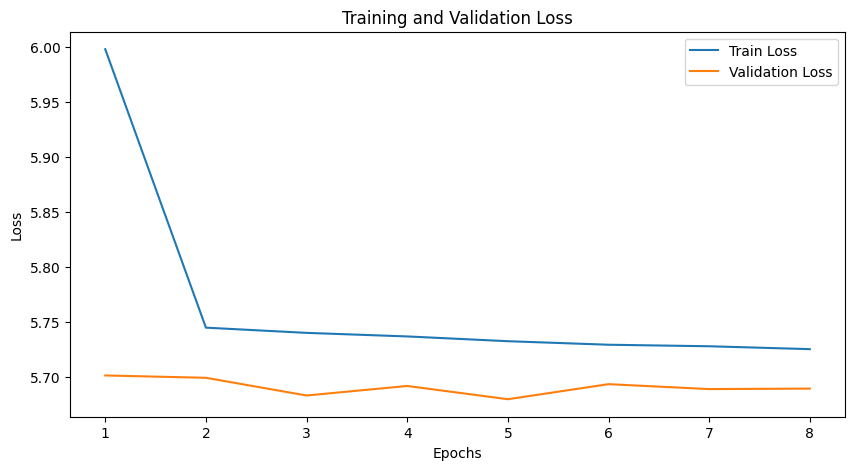

In [41]:
#Hyperparameters
max_len=256
embed_dim=512
n_layers=6
n_heads=8
d_ff=2048
dropout=0.1
batch_size=32
learning_rate=5e-4

src_vocab=tokenizer.vocab_size
tgt_vocab=tokenizer.vocab_size
model=Transformer(src_vocab,tgt_vocab,embed_dim,n_layers,n_heads,d_ff,dropout).to(device)
criterion=nn.CrossEntropyLoss(ignore_index=0)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
scheduler=LambdaLR(optimizer,lr_lambda=lambda epoch: 0.95 ** epoch)
num_epochs=25 
patience=3 

best_val_loss=float('inf')
patience_counter=0
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader,desc=f"Training Epoch {epoch+1}",leave=False):
        src=batch['english'].to(device)
        tgt=batch['urdu'].to(device)
        optimizer.zero_grad()
        output=model(src,tgt[:,:-1])
        loss=criterion(output.view(-1,output.shape[-1]),tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    #Calculate average training loss for this epoch
    avg_train_loss=epoch_loss/len(train_loader)
    train_losses.append(avg_train_loss)   
    #Validation loss
    model.eval()
    epoch_loss=0
    with torch.no_grad():
        for batch in val_loader:
            src=batch['english'].to(device)
            tgt=batch['urdu'].to(device)
            output=model(src,tgt[:, :-1])
            loss=criterion(output.view(-1,output.shape[-1]),tgt[:,1:].reshape(-1))
            epoch_loss+=loss.item()
    val_loss=epoch_loss/len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

    #Early stopping check
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        patience_counter=0
        torch.save(model.state_dict(),'/kaggle/working/model.pth')
    else:
        patience_counter+=1
        if patience_counter>=patience:
            print("Early stopping...")
            break

#Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(range(1,len(train_losses)+1),train_losses,label='Train Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [42]:
torch.save(model.state_dict(),'model.pth')

### Evaluation

In [43]:
model.load_state_dict(torch.load('/kaggle/working/model.pth'))
model.eval()

#Generate predictions
predictions=[]
references=[]
attention_maps=[]
with torch.no_grad():
    for batch in test_loader:
        src,tgt=batch['english'].to(device),batch['urdu'].to(device)
        output=model(src, tgt[:,:-1])
        predicted=output.argmax(-1).cpu().tolist()
        predictions.extend(predicted)
        references.extend(tgt[:,1:].cpu().tolist())
#Bleu Score
bleu_score=corpus_bleu([[ref] for ref in references],predictions)

#Rouge Score
rouge=Rouge()
decoded_predictions=[tokenizer.decode(pred,skip_special_tokens=True)for pred in predictions]
decoded_references=[tokenizer.decode(ref,skip_special_tokens=True)for ref in references]
rouge_scores=rouge.get_scores(decoded_predictions,decoded_references,avg=True)


print(f"BLEU Score: {bleu_score:.4f}")
print(f"ROUGE Scores: {rouge_scores}")

BLEU Score: 0.3388
ROUGE Scores: {'rouge-1': {'r': 0.03344847999007943, 'p': 0.74, 'f': 0.0636734357166433}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.03344847999007943, 'p': 0.74, 'f': 0.0636734357166433}}


## 2. LSTM Based Translation

### Preprocessing

In [8]:
#Build Vocabularies
tokens=list(itertools.chain(*train_df['english']))
en_vocab={token:idx for idx,token in enumerate(set(tokens),start=1)}
en_vocab['<PAD>']=0

tokens=list(itertools.chain(*train_df['urdu']))
ur_vocab={token:idx for idx,token in enumerate(set(tokens),start=1)}
ur_vocab['<PAD>']=0

def encode_sentence(sentence,vocab):
    return [vocab.get(word,vocab['<PAD>']) for word in sentence]

class TranslationDataset(Dataset):
    def __init__(self,df,en_vocab,ur_vocab,max_length=20):
        self.english=df['english'].apply(lambda x:encode_sentence(x,en_vocab))
        self.urdu=df['urdu'].apply(lambda x:encode_sentence(x,ur_vocab))
        self.max_length=max_length
    def __len__(self):
        return len(self.english)
    def __getitem__(self,idx):
        en_seq=self.english[idx][:self.max_length]
        ur_seq=self.urdu[idx][:self.max_length]
        en_seq+=[0]*(self.max_length-len(en_seq))
        ur_seq+=[0]*(self.max_length-len(ur_seq))
        return torch.tensor(en_seq),torch.tensor(ur_seq)

#Initialize the dataset and dataloader
train_dataset=TranslationDataset(train_df,en_vocab,ur_vocab)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

### LSTM Model

In [45]:
class LSTM(nn.Module):
    def __init__(self,en_vocab_size,ur_vocab_size,embedding_dim,hidden_dim):
        super(LSTM,self).__init__()
        self.encoder_embedding=nn.Embedding(en_vocab_size,embedding_dim)
        self.decoder_embedding=nn.Embedding(ur_vocab_size,embedding_dim)
        self.encoder_lstm=nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.decoder_lstm=nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.fc=nn.Linear(hidden_dim,ur_vocab_size)
    def forward(self,en_seq,ur_seq):
        #Encoder
        en_embedded=self.encoder_embedding(en_seq)
        _,(hidden,cell)=self.encoder_lstm(en_embedded)
        #Decoder
        ur_embedded=self.decoder_embedding(ur_seq)
        decoder_output,_=self.decoder_lstm(ur_embedded,(hidden,cell))
        #Fully connected layer
        output=self.fc(decoder_output)
        return output

### Training

Epoch 1/10, Loss: 5.8175


Epoch 2/10, Loss: 4.9232


Epoch 3/10, Loss: 4.4864


Epoch 4/10, Loss: 4.1180


Epoch 5/10, Loss: 3.7839


Epoch 6/10, Loss: 3.4633


Epoch 7/10, Loss: 3.1404


Epoch 8/10, Loss: 2.8242


Epoch 9/10, Loss: 2.5165


Epoch 10/10, Loss: 2.2186


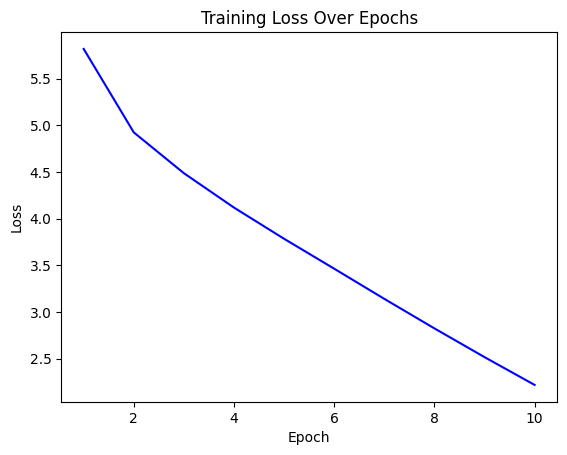

In [46]:
#HyperParameters
embedding_dim=256
hidden_dim=512
en_vocab_size=len(en_vocab)
ur_vocab_size=len(ur_vocab)

model=LSTM(en_vocab_size,ur_vocab_size,embedding_dim,hidden_dim).to(device)
criterion=nn.CrossEntropyLoss(ignore_index=0)
optimizer=optim.Adam(model.parameters(),lr=0.001)

#Track losses
epoch_losses=[]

#Training loop
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    total_loss=0
    progress_bar=tqdm(train_loader,desc=f"Epoch {epoch + 1}/{num_epochs}",leave=False)
    for src,tgt in progress_bar:
        src,tgt=src.to(device),tgt.to(device)
        optimizer.zero_grad()
        tgt1=tgt[:,:-1]
        tgt2=tgt[:,1:]
        output=model(src,tgt1)
        output=output.reshape(-1,ur_vocab_size)
        loss=criterion(output,tgt2.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    avg_loss=total_loss/len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

#Plot loss curve
plt.plot(range(1,num_epochs+1),epoch_losses,color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

### Evaluation

In [47]:
#Evaluate on the test set
test_loader=DataLoader(TranslationDataset(test_df,en_vocab,ur_vocab),batch_size=1)
bleu_scores=[]
rouge=Rouge()
rouge_scores=[]
index_to_word={idx:word for word,idx in ur_vocab.items()}

for src,tgt in test_loader:
    src,tgt=src.to(device),tgt.to(device)
    for i in range(len(src)):
        reference=[index_to_word[idx.item()] for idx in tgt[i] if idx.item()>0]
        model.eval()
        src=src.to(device)
        with torch.no_grad():
            tgt_input=torch.zeros_like(src).to(device)
            output=model(src,tgt_input)
            _,predicted=torch.max(output,dim=2)
            translated_sentence=[list(ur_vocab.keys())[idx] for idx in predicted[0] if idx>0]
        hypothesis=translated_sentence
        
        #Calculate BLEU score
        bleu_score=sentence_bleu([reference],hypothesis)
        bleu_scores.append(bleu_score)

        reference_str=" ".join(reference)
        hypothesis_str=" ".join(hypothesis)
        #Calculate ROUGE score
        rouge_score=rouge.get_scores(hypothesis_str,reference_str,avg=True)
        rouge_scores.append(rouge_score)

#Average scores
avg_bleu=np.mean(bleu_scores)
avg_rouge={
    'rouge-1': np.mean([score['rouge-1']['f'] for score in rouge_scores]),
    'rouge-2': np.mean([score['rouge-2']['f'] for score in rouge_scores]),
    'rouge-l': np.mean([score['rouge-l']['f'] for score in rouge_scores])
}
print(f"BLEU Score:{avg_bleu:.4f}")
print("ROUGE Scores:",avg_rouge)

BLEU Score:0.0000
ROUGE Scores: {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}


## Bonus Task : Pretrained Model

### Load Pretrained Model and Preprocess Data

In [11]:
model_name="google/mt5-small"
tokenizer=MT5Tokenizer.from_pretrained(model_name)
model=MT5ForConditionalGeneration.from_pretrained(model_name).to(device)

In [12]:
def prepare_translation_data(data):
    en_texts=data['english'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x,list) else x).tolist()
    ur_texts=data['urdu'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x,list) else x).tolist()
    print(en_texts[:5])
    print(ur_texts[:5])

    #Tokenize
    inputs=tokenizer(en_texts,max_length=128,truncation=True,padding="max_length",return_tensors="pt")
    targets=tokenizer(ur_texts,max_length=128,truncation=True,padding="max_length",return_tensors="pt")
    return inputs,targets

train_inputs,train_targets=prepare_translation_data(train_df)
val_inputs,val_targets=prepare_translation_data(val_df)
test_inputs,test_targets=prepare_translation_data(test_df)

['the book of the generation of jesus christ the son of david the son of abraham', 'abraham begat isaac and isaac begat jacob and jacob begat judas and his brethren', 'and judas begat phares and zara of thamar and phares begat esrom and esrom begat aram', 'and aram begat aminadab and aminadab begat naasson and naasson begat salmon', 'and salmon begat booz of rachab and booz begat obed of ruth and obed begat jesse']
['یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ', 'ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پیدا ہوا اور یعقوب سے یہوداہ اور اس کے بھائی پیدا ہوئے', 'اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے اور فارص سے حصرون پیدا ہوا اور حصرون سے رام پیدا ہوا', 'اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحسون پیدا ہوا اور نحسون سے سلمون پیدا ہوا', 'اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے عوبید روت سے پیدا ہوا اور عوبید سے یسی پیدا ہوا']
['this then is the message which we have heard of him and declare unto you that god is light and in him is no darkness at all', 'if we say that 

### Prepare Dataloaders

In [13]:
class TranslationDataset(Dataset):
    def __init__(self,inputs,targets):
        self.inputs=inputs
        self.targets=targets
    def __len__(self):
        return len(self.inputs["input_ids"])
    def __getitem__(self,idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": self.targets["input_ids"][idx],
        }

train_dataset=TranslationDataset(train_inputs,train_targets)
val_dataset=TranslationDataset(val_inputs,val_targets)
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16)

### Finetune The Model

In [14]:
optimizer=AdamW(model.parameters(),lr=5e-5)
scheduler=StepLR(optimizer,step_size=1,gamma=0.9)
criterion=torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
num_epochs=5
for epoch in range(num_epochs):
    model.train()
    train_loss=0
    for batch in tqdm(train_loader,desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids=batch["input_ids"].to(device)
        attention_mask=batch["attention_mask"].to(device)
        labels=batch["labels"].to(device)
        outputs=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
        loss=outputs.loss
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f}")


Training Epoch 1: 100%|██████████| 463/463 [03:23<00:00,  2.28it/s]


Epoch 1 | Train Loss: 19.8973


Training Epoch 2: 100%|██████████| 463/463 [03:22<00:00,  2.29it/s]


Epoch 2 | Train Loss: 4.6622


Training Epoch 3: 100%|██████████| 463/463 [03:22<00:00,  2.29it/s]


Epoch 3 | Train Loss: 2.9223


Training Epoch 4: 100%|██████████| 463/463 [03:22<00:00,  2.28it/s]


Epoch 4 | Train Loss: 2.5430


Training Epoch 5: 100%|██████████| 463/463 [03:22<00:00,  2.28it/s]

Epoch 5 | Train Loss: 2.3478


### Evaluation

In [15]:
model.eval()
predictions=[]
references=[]
with torch.no_grad():
    for batch in val_loader:
        input_ids=batch["input_ids"].to(device)
        attention_mask=batch["attention_mask"].to(device)
        generated_ids=model.generate(input_ids=input_ids,attention_mask=attention_mask,max_length=128)
        predictions.extend([tokenizer.decode(ids,skip_special_tokens=True) for ids in generated_ids])
        references.extend([tokenizer.decode(ids,skip_special_tokens=True) for ids in batch["labels"]])
bleu_score=corpus_bleu([[ref.split()] for ref in references],[pred.split() for pred in predictions])
rouge=Rouge()
rouge_scores=rouge.get_scores(predictions,references,avg=True)

print(f"BLEU Score: {bleu_score:.4f}")
print(f"ROUGE Scores: {rouge_scores}")

BLEU Score: 0.0000
ROUGE Scores: {'rouge-1': {'r': 0.033991286122319414, 'p': 0.24066666666666672, 'f': 0.0588388629180315}, 'rouge-2': {'r': 0.0014061866303083158, 'p': 0.011388888888888888, 'f': 0.0024470158209082544}, 'rouge-l': {'r': 0.03179392093674827, 'p': 0.2261111111111113, 'f': 0.05504320640522522}}
